In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

22/10/09 23:19:25 WARN Utils: Your hostname, HOMELAB resolves to a loopback address: 127.0.1.1; using 172.25.200.109 instead (on interface eth0)
22/10/09 23:19:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/09 23:19:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import multiprocessing.pool
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from cycler import cycler
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)

plt.rc('axes', labelsize=15, titlesize=15) 
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=15)

# Throughput

In [5]:
THRP_PREFIX = "main/ycsb"

IGNORE_CACHE = False

thrp_index_df = from_cache_or_compute(
    f'{THRP_PREFIX}/index.parquet',
    lambda: get_index(spark, THRP_PREFIX).toPandas().convert_dtypes().astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
        "wl:mp": "int32"
    }),
    ignore_cache=IGNORE_CACHE,
)
thrp_index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:hot_records,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home
0,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot10000mp100mh100,1.0.1075,ddr_ts.conf,60,2000000,3000,3750,10,basic,100,...,2,1,2,10000,100,2,10,1,-1,-1
1,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot10000mp100mh100,1.0.1075,ddr_only.conf,60,2000000,3000,3750,10,basic,100,...,2,1,2,10000,100,2,10,1,-1,-1
2,file:/home/ctring/data/detock/main/ycsb/baselinex-hot10000mp100mh100,1.0.1082,baselinex.conf,60,2000000,3000,3750,10,basic,100,...,2,1,2,10000,100,2,10,1,-1,-1
3,file:/home/ctring/data/detock/main/ycsb/baseline-hot10000mp100mh100,1.0.1082,baseline.conf,60,2000000,3000,3750,10,basic,100,...,2,1,2,10000,100,2,10,1,-1,-1
4,file:/home/ctring/data/detock/main/ycsb/baseline-hot10000mp100mh50,1.0.1082,baseline.conf,60,2000000,3000,4625,10,basic,50,...,2,1,2,10000,100,2,10,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,file:/home/ctring/data/detock/main/ycsb/calvin-hot100mp0mh100,1.0.1075,calvin.conf,30,200000,3000,0,10,basic,100,...,2,1,2,100,100,2,10,1,-1,-1
195,file:/home/ctring/data/detock/main/ycsb/calvin-hot100mp50mh0,1.0.1075,calvin.conf,60,2000000,3000,0,10,basic,0,...,2,1,2,100,100,2,10,1,-1,-1
196,file:/home/ctring/data/detock/main/ycsb/calvin-hot100mp0mh0,1.0.1075,calvin.conf,30,200000,3000,0,10,basic,0,...,2,1,2,100,100,2,10,1,-1,-1
197,file:/home/ctring/data/detock/main/ycsb/calvin-hot100mp0mh75,1.0.1075,calvin.conf,30,200000,3000,0,10,basic,75,...,2,1,2,100,100,2,10,1,-1,-1


In [6]:
def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=10,
        duration_sec=50,
    ).first().throughput
    return res


def compute_all_throughputs(index_df):
    prefix = list(index_df["prefix"])

    # Compute the throughput of each prefix
    with multiprocessing.pool.ThreadPool() as pool:
        res = pool.map(compute_throughput, prefix)
    
    # Construct a dataframe from the results
    throughput_df = pd.DataFrame({"prefix": prefix, "throughput": res})

    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")

In [8]:
IGNORE_CACHE = False

throughput_df = from_cache_or_compute(
    f'{THRP_PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(thrp_index_df),
    ignore_cache=IGNORE_CACHE,
)

throughput_df

,prefix,throughput,version,config_name,duration,txns,clients,rate,sample,wl:name,...,wl:hot_records,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home
index,,,,,,,,,,,,,,,,,,,,,
0,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot10000mp100mh100,29015.924560,1.0.1075,ddr_ts.conf,60,2000000,3000,3750,10,basic,...,2,1,2,10000,100,2,10,1,-1,-1
1,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot10000mp100mh100,29704.323511,1.0.1075,ddr_only.conf,60,2000000,3000,3750,10,basic,...,2,1,2,10000,100,2,10,1,-1,-1
2,file:/home/ctring/data/detock/main/ycsb/baselinex-hot10000mp100mh100,15714.621855,1.0.1082,baselinex.conf,60,2000000,3000,3750,10,basic,...,2,1,2,10000,100,2,10,1,-1,-1
3,file:/home/ctring/data/detock/main/ycsb/baseline-hot10000mp100mh100,25862.522183,1.0.1082,baseline.conf,60,2000000,3000,3750,10,basic,...,2,1,2,10000,100,2,10,1,-1,-1
4,file:/home/ctring/data/detock/main/ycsb/baseline-hot10000mp100mh50,31778.194952,1.0.1082,baseline.conf,60,2000000,3000,4625,10,basic,...,2,1,2,10000,100,2,10,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,file:/home/ctring/data/detock/main/ycsb/calvin-hot100mp0mh100,65275.971527,1.0.1075,calvin.conf,30,200000,3000,0,10,basic,...,2,1,2,100,100,2,10,1,-1,-1
195,file:/home/ctring/data/detock/main/ycsb/calvin-hot100mp50mh0,41758.853422,1.0.1075,calvin.conf,60,2000000,3000,0,10,basic,...,2,1,2,100,100,2,10,1,-1,-1
196,file:/home/ctring/data/detock/main/ycsb/calvin-hot100mp0mh0,64199.720072,1.0.1075,calvin.conf,30,200000,3000,0,10,basic,...,2,1,2,100,100,2,10,1,-1,-1


## Plot

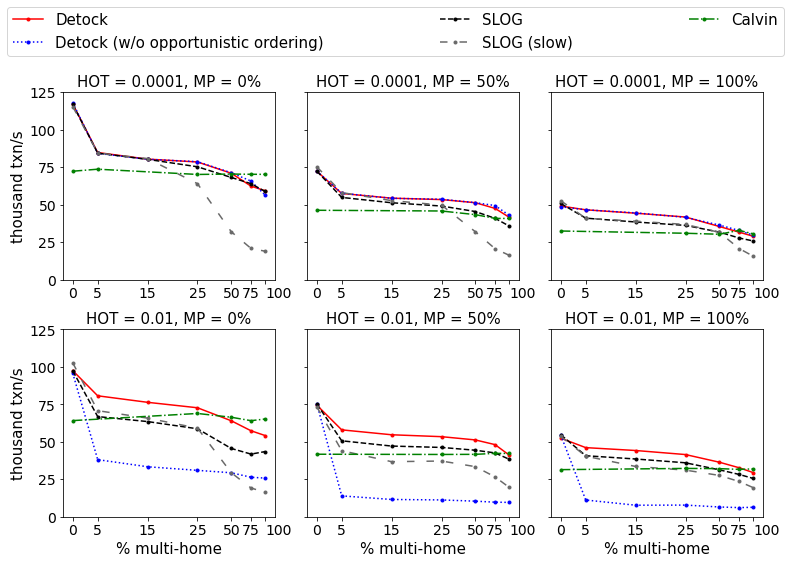

In [9]:
from matplotlib.ticker import MultipleLocator

fig, axes = plt.subplots(2, 3, figsize=(11, 7), sharey=True)

configs = [
    "ddr_ts.conf",
    "ddr_only.conf",
    "baseline.conf",
    "baselinex.conf",
    "calvin.conf",
]

mp_pcts = sorted(throughput_df["wl:mp"].unique())
mh_pcts = sorted(throughput_df["wl:mh"].unique())
hots = sorted(throughput_df["wl:hot"].unique(), reverse=True)

ignored_configs = []

config_to_label = {
    'baseline.conf': 'SLOG',
    'baselinex.conf': 'SLOG (slow)',
    'ddr_only.conf': 'Detock (w/o opportunistic ordering)',
    'ddr_ts.conf': 'Detock',
    "calvin.conf": 'Calvin',
}

pc = cycler(linestyle=['-', ':', '--', (0, (5, 8)), '-.']) + cycler(color=["red", "blue", "k", "dimgray", "g"])
for ax_r in axes:
    for ax in ax_r:
        ax.set_prop_cycle(pc)

for config in configs:
    if config in ignored_configs:
        continue
    for r, hot in enumerate(hots):
        for c, mp_pct in enumerate(mp_pcts):
            mask = (
                (throughput_df["config_name"] == config) &
                (throughput_df["wl:mp"] == mp_pct) &
                (throughput_df["wl:hot"] == hot)
            )
            label = config_to_label[config] if r == 0 and c == 0 else '_nolegend_'
            filtered = throughput_df[mask].sort_values("wl:mh")
            filtered["throughput2"] = filtered["throughput"] / 1000
            filtered.plot(
                ax=axes[r, c],
                x="wl:mh",
                y="throughput2",
                label=label,
                marker='.',
                legend=False,
            )
            axes[r, c].set_title(f"HOT = {1/hot}, MP = {mp_pct}%")
            axes[r, c].set_ylabel("thousand txn/s")
            axes[r, c].set_xticks(mh_pcts)
            axes[r, c].set_xscale("symlog", linthresh=25)
            axes[r, c].set_ylim(0, 125)
            axes[r, c].set_xticks([0, 5, 15, 25, 50, 75, 100])
            axes[r, c].set_xticklabels([0, 5, 15, 25, 50, 75, 100], rotation=0)

            # Realign the tick labels
            tick_label_100 = axes[r, c].xaxis.get_majorticklabels()[-1]
            tick_label_100.set_horizontalalignment("left")

            axes[r, c].minorticks_off()
            # axes[r, c].grid(axis='y')
            if r == len(hots) - 1:
                axes[r, c].set_xlabel("% multi-home")
            else:
                axes[r, c].set_xlabel(None)


fig.tight_layout()
fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', mode='expand', ncol=3)

fig.savefig('output/micro-throughput.pdf', bbox_inches='tight')
fig.savefig('output/micro-throughput.png', bbox_inches='tight')


# Deadlocks

In [7]:
deadlocks_index_df = thrp_index_df[(
    (thrp_index_df["wl:hot"] == 100) &
    (thrp_index_df["wl:mp"] == 100) &
    (
        (thrp_index_df["config_name"] == "ddr_ts.conf") |
        (thrp_index_df["config_name"] == "ddr_only.conf")
    )
)]
deadlocks_index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:hot_records,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home
51,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot100mp100mh100,1.0.1075,ddr_only.conf,60,2000000,3000,7500,10,basic,100,...,2,1,2,100,100,2,10,1,-1,-1
57,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot100mp100mh100,1.0.1075,ddr_ts.conf,60,2000000,3000,3750,10,basic,100,...,2,1,2,100,100,2,10,1,-1,-1
88,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot100mp100mh15,1.0.1075,ddr_only.conf,60,2000000,3000,7500,10,basic,15,...,2,1,2,100,100,2,10,1,-1,-1
92,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot100mp100mh75,1.0.1075,ddr_only.conf,60,2000000,3000,7500,10,basic,75,...,2,1,2,100,100,2,10,1,-1,-1
94,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot100mp100mh25,1.0.1075,ddr_only.conf,60,2000000,3000,7500,10,basic,25,...,2,1,2,100,100,2,10,1,-1,-1
95,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot100mp100mh50,1.0.1075,ddr_only.conf,60,2000000,3000,7500,10,basic,50,...,2,1,2,100,100,2,10,1,-1,-1
101,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot100mp100mh15,1.0.1075,ddr_ts.conf,60,2000000,3000,5625,10,basic,15,...,2,1,2,100,100,2,10,1,-1,-1
104,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot100mp100mh75,1.0.1075,ddr_ts.conf,60,2000000,3000,4150,10,basic,75,...,2,1,2,100,100,2,10,1,-1,-1
105,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot100mp100mh50,1.0.1075,ddr_ts.conf,60,2000000,3000,4625,10,basic,50,...,2,1,2,100,100,2,10,1,-1,-1
107,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot100mp100mh25,1.0.1075,ddr_ts.conf,60,2000000,3000,5250,10,basic,25,...,2,1,2,100,100,2,10,1,-1,-1


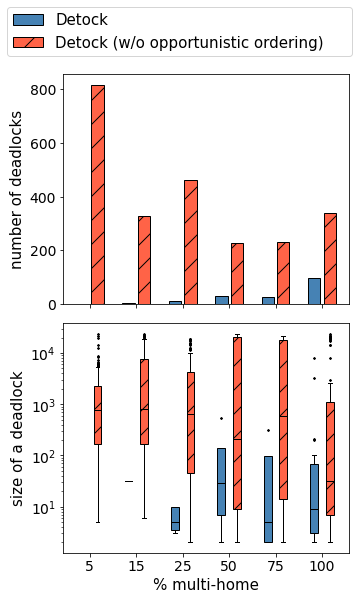

In [8]:
IGNORE_CACHE = False

import pickle

mh_pcts = [5, 15, 25, 50, 75, 100]

configs = ["ddr_ts.conf", "ddr_only.conf"]

config_to_label = {
    'ddr_only.conf': 'Detock (w/o opportunistic ordering)',
    'ddr_ts.conf': 'Detock'
}

# Collect data
DEADLOCKS_PATH = f'{THRP_PREFIX}/deadlocks.pickle'

data = []
if not IGNORE_CACHE and isfile(DEADLOCKS_PATH):
    with open(DEADLOCKS_PATH, 'rb') as f:
        data = pickle.load(f)
else:
    for config in configs:
        deadlocks = []
        num_txns = []
        for mh in mh_pcts:
            mask = (deadlocks_index_df["config_name"] == config) & (deadlocks_index_df["wl:mh"] == mh)
            prefix = deadlocks_index_df.loc[mask, "prefix"].iloc[0]
            
            deadlocks_df = deadlocks_csv(spark, prefix).where(col("replica") == 0).toPandas()

            deadlocks.append(deadlocks_df["vertices"])
            num_txns.append(committed(spark, prefix))

        data.append((deadlocks, num_txns))

    with open(DEADLOCKS_PATH, 'wb') as f:
        pickle.dump(data, f)
        print(f'Saved to: {DEADLOCKS_PATH}')

# Plot
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5, 7.5))
colors=['steelblue', 'tomato']
hatches = ['', '/']
for i, c in enumerate(configs):
    deadlocks, num_txns = data[i]
    data_cnt = list(map(lambda d : d[0].count(), zip(deadlocks, num_txns)))
    pos = [j * (len(configs) + 1) + i for j in range(len(data_cnt))]

    l = axes[0].bar(pos, data_cnt, label=config_to_label[c], hatch=hatches[i], facecolor=colors[i], edgecolor='k')
    # color = l.get_children()[-1].get_facecolor()

    box = axes[1].boxplot(
        deadlocks,
        flierprops={ 'markersize': 1 },
        medianprops={ 'color': 'black' },
        positions=pos,
        manage_ticks=False,
        patch_artist=True,
    )
    for b in box['boxes']:
        b.set_facecolor(colors[i])
        b.set_hatch(hatches[i])
        b.set_edgecolor('k')
    
ticks = []
ticklabels = []
for i, mh in enumerate(mh_pcts):
    start = i * (len(configs) + 1)
    end = start + len(configs)
    ticks.append((start + end - 1) / 2)
    ticklabels.append(f'{mh}')
    
axes[0].set_ylabel('number of deadlocks')
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(ticklabels)
# axes[0].grid(axis='y')

axes[1].set_xlabel("% multi-home")
axes[1].set_ylabel('size of a deadlock')
axes[1].set_yscale("log")
# axes[1].grid(axis='y')

fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', mode='expand', ncol=1)
fig.tight_layout()
fig.savefig('output/micro-deadlocks.pdf', bbox_inches='tight')

# Latency

In [10]:
LAT_PREFIX = "main/ycsb-latency"

IGNORE_CACHE = False

lat_index_df = from_cache_or_compute(
    f'{LAT_PREFIX}/index.parquet',
    lambda: get_index(spark, LAT_PREFIX).toPandas().convert_dtypes().astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
        "wl:mp": "int32"
    }),
    ignore_cache=IGNORE_CACHE
)

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("percentile_50"),
    F.percentile_approx("latency", 0.99).alias("percentile_99"),
]

lat_index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:hot_records,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home
0,file:/home/ctring/data/detock/main/ycsb-latency/calvin-hot10000mp0mh100,1.0.1075,calvin.conf,30,2000000,1000,1000,10,basic,100,...,2,1,2,10000,100,2,10,1,-1,-1
1,file:/home/ctring/data/detock/main/ycsb-latency/calvin-hot10000mp50mh100,1.0.1075,calvin.conf,30,2000000,1000,1000,10,basic,100,...,2,1,2,10000,100,2,10,1,-1,-1
2,file:/home/ctring/data/detock/main/ycsb-latency/calvin-hot10000mp50mh50,1.0.1075,calvin.conf,30,2000000,1000,1000,10,basic,50,...,2,1,2,10000,100,2,10,1,-1,-1
3,file:/home/ctring/data/detock/main/ycsb-latency/calvin-hot10000mp50mh25,1.0.1075,calvin.conf,30,2000000,1000,1000,10,basic,25,...,2,1,2,10000,100,2,10,1,-1,-1
4,file:/home/ctring/data/detock/main/ycsb-latency/calvin-hot10000mp0mh50,1.0.1075,calvin.conf,30,2000000,1000,1000,10,basic,50,...,2,1,2,10000,100,2,10,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,file:/home/ctring/data/detock/main/ycsb-latency/ddr_ts-hot100mp100mh0,1.0.1075,ddr_ts.conf,20,300000,15,1000,10,basic,0,...,2,1,2,100,100,2,10,1,-1,-1
84,file:/home/ctring/data/detock/main/ycsb-latency/calvin-hot100mp100mh0,1.0.1075,calvin.conf,30,300000,20,100,10,basic,0,...,2,1,2,100,100,2,10,1,-1,-1
85,file:/home/ctring/data/detock/main/ycsb-latency/ddr_only-hot100mp100mh5,1.0.1075,ddr_only.conf,20,300000,15,1000,10,basic,5,...,2,1,2,100,100,2,10,1,-1,-1
86,file:/home/ctring/data/detock/main/ycsb-latency/ddr_ts-hot100mp100mh5,1.0.1075,ddr_ts.conf,20,300000,15,1000,10,basic,5,...,2,1,2,100,100,2,10,1,-1,-1


In [11]:
IGNORE_CACHE = False

latency_pct_sh_df = from_cache_or_compute(
    f'{LAT_PREFIX}/latency_sh.parquet',
    lambda: latency(
        spark,
        lat_index_df["prefix"],
        sample=1.0,
        start_offset_sec=10,
    )\
        .where(F.size("regions") == 1)\
        .groupBy("prefix")\
        .agg(*percentile_cols)\
        .toPandas()\
        .merge(lat_index_df, on="prefix"),
    ignore_cache=IGNORE_CACHE,
)

In [12]:
IGNORE_CACHE = False

# For MH transactions, we resample the results so that the numbers of transactions
# are even across the regions

mh_df = latency(
    spark,
    lat_index_df["prefix"],
    sample=1.0,
    start_offset_sec=5,
    duration_sec=20,
)\
    .withColumn("region", F.shiftright(F.col("coordinator"), 24))\
    .withColumn("key", F.concat(F.col("prefix"), F.col("region")))\
    .where(F.size("regions") > 1)\
    .cache()

sampling_frac = mh_df\
    .groupBy("key")\
    .count()\
    .withColumn("frac", F.least(F.lit(1), 200/F.col("count")))\
    .select("key", "frac")

latency_pct_mh_df = from_cache_or_compute(
    f'{LAT_PREFIX}/latency_mh.parquet',
    lambda: mh_df\
        .sampleBy(
            "key",
            sampling_frac.toPandas().set_index("key").to_dict()["frac"],
            seed=1000,
        )\
        .groupBy("prefix")\
        .agg(*percentile_cols).toPandas()\
        .merge(lat_index_df, on="prefix"),
    ignore_cache=IGNORE_CACHE,
)

In [10]:
latency_pct_mh_df

,prefix,percentile_50,percentile_99,version,config_name,duration,txns,clients,rate,sample,...,wl:hot_records,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home
index,,,,,,,,,,,,,,,,,,,,,
0,file:/home/ctring/data/detock/main/ycsb-latency/baseline-hot10000mp100mh100,188.086784,279.140352,1.0.1075,baseline.conf,20,300000,15,1000,10,...,2,1,2,10000,100,2,10,1,-1,-1
1,file:/home/ctring/data/detock/main/ycsb-latency/ddr_only-hot10000mp100mh100,91.145216,273.255424,1.0.1075,ddr_only.conf,20,300000,15,1000,10,...,2,1,2,10000,100,2,10,1,-1,-1
2,file:/home/ctring/data/detock/main/ycsb-latency/ddr_ts-hot10000mp100mh100,91.706112,274.891008,1.0.1075,ddr_ts.conf,20,300000,15,1000,10,...,2,1,2,10000,100,2,10,1,-1,-1
3,file:/home/ctring/data/detock/main/ycsb-latency/baseline-hot10000mp100mh10,193.407744,285.182720,1.0.1075,baseline.conf,20,300000,15,1000,10,...,2,1,2,10000,100,2,10,1,-1,-1
4,file:/home/ctring/data/detock/main/ycsb-latency/baseline-hot10000mp100mh20,191.127552,283.183616,1.0.1075,baseline.conf,20,300000,15,1000,10,...,2,1,2,10000,100,2,10,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,file:/home/ctring/data/detock/main/ycsb-latency/ddr_ts-hot100mp100mh15,101.341440,274.905344,1.0.1075,ddr_ts.conf,20,300000,15,1000,10,...,2,1,2,100,100,2,10,1,-1,-1
55,file:/home/ctring/data/detock/main/ycsb-latency/baseline-hot100mp100mh5,200.504576,281.405952,1.0.1075,baseline.conf,20,300000,15,1000,10,...,2,1,2,100,100,2,10,1,-1,-1
56,file:/home/ctring/data/detock/main/ycsb-latency/ddr_ts-hot100mp100mh75,101.027328,275.168512,1.0.1075,ddr_ts.conf,20,300000,15,1000,10,...,2,1,2,100,100,2,10,1,-1,-1


## Plot

In [61]:
import matplotlib.ticker as ticker 

def plot_one_latency(df, label, config, hot, mp_pct, mh_pcts, ax):
    mask = (
        (df["config_name"] == config) &
        (df["wl:hot"] == hot) &
        (df["wl:mp"] == mp_pct) &
        (df["wl:mh"].isin(mh_pcts))
    )
    filtered = df[mask].sort_values("wl:mh")
    filtered.plot(ax=ax, x="wl:mh", y="percentile_50", label=label.format('p50'), legend=False)
    # filtered.plot(ax=ax, x="wl:mh", y="percentile_95", label=label.format('p95'), legend=False)
    filtered.plot(ax=ax, x="wl:mh", y="percentile_99", label=label.format('p99'), legend=False)

    ax.set_title(f"HOT = {1/hot}, MP = {mp_pct}%")
    ax.set_ylabel("latency (ms)")
    # ax.set_yscale("log")
    ax.set_xlabel("% multi-home")
    ax.set_xscale("symlog", linthresh=15)
    ax.set_xticks(mh_pcts)
    ax.set_xticklabels(mh_pcts, rotation=0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    #ax.grid(visible=None)


def plot_latency(
    df,
    mp_pcts=[0, 50, 100],
    mh_pcts=[0, 5, 10, 15, 25, 50, 75, 100],
    hots=[10000, 100],
    figsize=(11, 7),
    legend=True,
    fig_axes=None,
):
    configs = [
        "ddr_ts.conf",
        # "ddr_only.conf",
        "baseline.conf"
    ]

    config_to_label = {
        'ddr_ts.conf': 'Detock',
        'baseline.conf': 'SLOG',
        # 'calvin.conf': 'Calvin',
        # 'ddr_only.conf': 'Detock w.o OO',
    }

    if fig_axes:
        fig, axes = fig_axes
    else:
        fig, axes = plt.subplots(len(hots), len(mp_pcts), figsize=figsize, sharey=True)
        axes = np.array(axes).reshape((len(hots), len(mp_pcts)))

    pc = (cycler(color='rkgb') + cycler(marker=['.', 'x', '+', 'o'])) * cycler(linestyle=['--', '-'])
    for ax_r in axes:
        for ax in ax_r:
            ax.set_prop_cycle(pc)

    for i, config in enumerate(configs):
        for r, hot in enumerate(hots):   
            for c, mp_pct in enumerate(mp_pcts):
                plot_one_latency(
                    df,
                    config_to_label[config] + ' {}' if r == 0 and c == 0 else '_nolegend_',
                    config,
                    hot,
                    mp_pct,
                    mh_pcts,
                    axes[r, c],
                )

    if legend:
        fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', mode='expand', ncol=3)

    return fig, axes


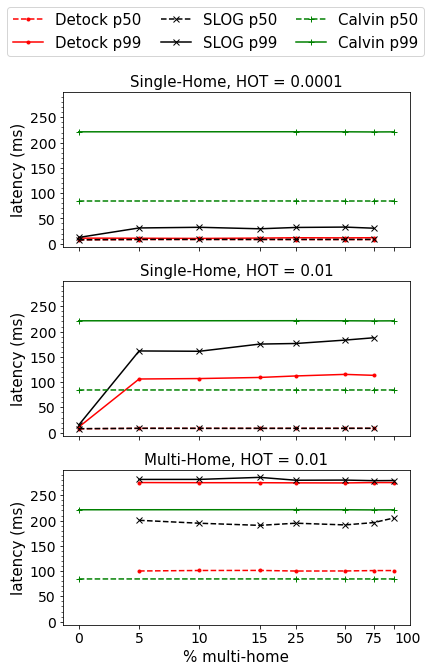

In [63]:
configs = [
    "ddr_ts.conf",
    # "ddr_only.conf",
    "baseline.conf",
    # "calvin.conf"
]

config_to_label = {
    'ddr_ts.conf': 'Detock',
    'baseline.conf': 'SLOG',
    # 'ddr_only.conf': 'Detock w.o OO',
    'calvin.conf': "Calvin",
}

fig, axes = plt.subplots(3, 1, figsize=(6, 8.5), sharex=True, sharey=True)
axes = np.array(axes).reshape((3, 1))

plot_latency(
    latency_pct_sh_df,
    mp_pcts=[100],
    mh_pcts=[0, 5, 10, 15, 25, 50, 75],
    figsize=(6, 6),
    legend=False,
    fig_axes=(fig, axes),
)

for config in configs:
    plot_one_latency(
        latency_pct_mh_df,
        label=label,
        config=config,
        hot=100,
        mp_pct=100,
        mh_pcts=[5, 10, 15, 25, 50, 75, 100],
        ax=axes[2, 0],
    )

first = True
for i in range(3):
    label = '_nolegend_' if not first else config_to_label["calvin.conf"] + ' {}'
    plot_one_latency(
        latency_pct_sh_df,
        label=label,
        config="calvin.conf",
        hot=100,
        mp_pct=100,
        mh_pcts=[0, 5, 10, 15, 25, 50, 75, 100],
        ax=axes[i, 0],
    )
    first = False


axes[0, 0].set_title("Single-Home, HOT = 0.0001")
axes[0, 0].set_xlabel(None)
axes[1, 0].set_title("Single-Home, HOT = 0.01")
axes[1, 0].set_xlabel(None)
axes[2, 0].set_title("Multi-Home, HOT = 0.01")
last_tick_label = axes[2, 0].xaxis.get_majorticklabels()[-1]
last_tick_label.set_horizontalalignment("left")


fig.legend(bbox_to_anchor=(0, 1, 1, 0), mode='expand', ncol=3, loc='lower left')
fig.tight_layout()
fig.savefig('output/micro-latency.pdf', bbox_inches='tight')
fig.savefig('output/micro-latency.png', bbox_inches='tight')